In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore

class NewPID:
    def __init__(self, intertia, dt=0.1, max_torque = 5, overshoot_threshold=0.5, ideal_convergence_time = 5, accel_damping = 0.01, logging = False):
        self.intertia = intertia
        self.kp = 0.01
        self.ki = 0.01
        self.kd = 0.01
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0
        self.dt = dt
        self.max_torque = max_torque
        self.overshoot_threshold = overshoot_threshold
        self.ideal_convergence_time = ideal_convergence_time
        self.logging = logging
        self.accel_damping = accel_damping # Acceleration cannot be instant, so we have to dampen it a bit
        self.acceleration = 0
        self.trained_difference = 0

        # Variables to keep track of data
        self.accelerations = []


    
    def newton_second_law(self, torque):
        """ Computes acceleration based on Newton's second law of motion. """
        output = min(self.max_torque, torque) / self.intertia
        return output

    def simulate_motion(self, rqst_velocity, params : dict = None):
        """ Simulates motion based on the torque input and updates the rqst_velocity. """
        if params is None:
            params = {"kp": self.kp, "ki": self.ki, "kd": self.kd}

        torque = self.compute_value_based_on_pid(rqst_velocity, params=params)
        
        # Compute acceleration based on the torque, but use the diff between the requested acceleration and the actual acceleration
        self.acceleration = self.acceleration + np.sign(self.newton_second_law(torque) - self.acceleration) * min(abs(self.acceleration - self.newton_second_law(torque)), self.accel_damping)

        if self.logging:
            self.accelerations.append(self.acceleration)

        # Update velocity considering the momentum
        self.actual_velocity += (self.acceleration * self.dt)
        return self.actual_velocity
    
    def moving_average(self, data, window_size=5):
        padded_data = np.pad(data, (window_size//2, window_size-1-window_size//2), mode='edge')
        return np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')

    def compute_value_based_on_pid(self, rqst_velocity, update_values=True, params : dict = None):
        """ 
        Computes the PID value based on the error and the PID constants.
        For our purposes, this outputs the torque value 
        """
        if params is None:
            params = {"kp": self.kp, "ki": self.ki, "kd": self.kd}
        
        error = rqst_velocity - self.actual_velocity
        derivative = (error - self.prev_error) / self.dt if self.dt > 0 else 0

        if update_values:
            self.integral += error
            self.prev_error = error
        output = params.get("kp") * error + params.get("ki") * self.integral + params.get("kd") * derivative

        if abs(output) > self.max_torque:
            output = np.sign(output) * self.max_torque
            
        return output
    
    def compute_error_grad(self, goal, max_time=100, params : dict = None):

        """"
        Params is the dictionary of PID values to be used for the simulation.
        """

        self.reset()

        total_error = 0
        max_velocity = 0
        data = []
        oscillations = 0
        convergence_time = 0

        time = np.arange(0, max_time, self.dt)
        for t_time in time:
            velocity = self.simulate_motion(goal, params)
            total_error += abs(goal - velocity)
            max_velocity = max(max_velocity, velocity)  # Track the max velocity
            data.append(velocity)

            # Track the oscillations that have an exceedingly high amplitude
            if len(data) > 1 and data[-1] < data[-2] and data[-2] > goal and abs(data[-2] - goal) > 0.5:
                oscillations += 1
            


        convergence_time = self.compute_convergence_time(goal, max_time, params)[0]

        # Penailty is relative to how far the max velocity is from the goal
        penality = abs(max_velocity - goal) 

        # Apply a penalty for oscillations
        penality += oscillations 

        # Decrease the penalty if the system converges quickly
        convergence_error = abs(convergence_time - self.ideal_convergence_time) * 20
        penality += convergence_error

        # Check for overshoot and increase error if necessary
        total_error += penality

        total_error = (total_error / len(time)) # Normalize the error

        # print(f"{Fore.CYAN}Simulation complete for params: {params} with error: {total_error:.2f} and max velocity: {max_velocity:.2f}{Fore.RESET} and oscillations: {oscillations} and convergence time: {convergence_time:.2f}")

        return total_error, (max_velocity - goal), oscillations, convergence_time
    
    def auto_tune_gradient_descent(self, goal, max_iter=500, tolerance=1e-3, momentum=0.4, learning_rate = 10, auto_accept=True, max_time = 100):
        randomize_count = 0
        best_kp, best_ki, best_kd, best_overshoot, best_oscillations, best_convergence = self.kp, self.ki, self.kd, float('inf'), float('inf'), float('inf')
        params = {"kp": 0, "ki": 0, "kd": 0}
        velocities = {"kp": 0, "ki": 0, "kd": 0}  # Velocity for momentum

        best_error, _, _, _ = self.compute_error_grad(goal, max_time, params)

        for iteration in range(max_iter):
            base_error, _, _, _ = self.compute_error_grad(goal, max_time, params)
            improved = False

            gradients = {}

            for param in params.keys():
                original_value = params[param]
                params[param] += learning_rate
                new_error, _, _, _ = self.compute_error_grad(goal, max_time, params)
                grad = (new_error - base_error) / learning_rate
                velocities[param] = momentum * velocities[param] - learning_rate * grad
                params[param] = max(0, original_value + velocities[param])  # Ensure non-negative values
                gradients[param] = grad

            current_error, overshoot, oscillations, convergence_time = self.compute_error_grad(goal, max_time, params)

            if current_error < best_error - tolerance and overshoot < self.overshoot_threshold:
                best_kp, best_ki, best_kd, best_overshoot, best_oscillations, best_convergence = params["kp"], params["ki"], params["kd"], overshoot, oscillations, convergence_time
                best_error = current_error
                improved = True


            if not improved:
                learning_rate *= 0.98  # Reduce learning rate if no improvement
                randomize_count += 1
                # Since we haven't improved in a while, add a little randomness to the PID values
                params["kp"] = np.random.uniform(0, params["kp"] * 3)
                params["ki"] = np.random.uniform(0, params["ki"] * 3)
                params["kd"] = np.random.uniform(0, params["kd"] * 3)

            print(f"\rProgress: {Fore.GREEN}Iteration {iteration}/{max_iter} Best Error: {best_error:.2f} Best PID: Kp={best_kp}, Ki={best_ki}, Kd={best_kd} \
                Overshoot: {best_overshoot:.2f}  Oscillations: {best_oscillations:.2f}\
                {Fore.RED} Randomized: {randomize_count}\
                {Fore.CYAN} Convergence : {best_convergence}    \
                {Fore.RESET}", end="", flush=True)

        if auto_accept:
            self.kp, self.ki, self.kd = best_kp, best_ki, best_kd

        # if (len(best_data) == 0):
        #     print(f"Auto-tuning failed: No improvements made. Best PID: Kp={best_kp}, Ki={best_ki}, Kd={best_kd} Error={best_error}")
        #     raise Exception("Auto-tuning failed.")

        print("\n")

        print(f"Final Tuned PID, Gradient Method: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Error={best_error}, Overshoot={best_overshoot} Convergence Time={best_convergence}")

        return {"kp": best_kp, "ki": best_ki, "kd": best_kd}
    
    def auto_tune_range(self, goal, max_time=10, auto_accept=True):
        """Auto-tunes PID by testing a range of P, I, and D values and selecting the best based on total error and overshoot."""
        best_kp, best_ki, best_kd, best_overshoot, best_data = self.kp, self.ki, self.kd, float('inf'), []
        min_error = float('inf')
        max_overshoot = 0.5
        
        kp_range = np.linspace(0.01, 200, 30)  # Adjust range as needed
        ki_range = np.linspace(0.01, 200, 30)
        kd_range = np.linspace(0.01, 200, 30)
        
        for kp in kp_range:
            for ki in ki_range:
                for kd in kd_range:
                    self.kp, self.ki, self.kd = kp, ki, kd
                    overshoot_value = float('inf')
                    total_error = 0
                    
                    velocity_data = []
                    time = np.arange(0, max_time, self.dt)
                    
                    for t in time:
                        velocity = self.simulate_motion(goal)
                        velocity_data.append(velocity)
                        total_error += abs(goal - velocity)

                    # Smooth out the data using a moving average
                    smoothed_data = self.moving_average(velocity_data, window_size=5)

                    # Find the first peak to calculate overshoot
                    first_value = smoothed_data[0]
                    for i in range(1, len(smoothed_data) - 1):
                        if len(smoothed_data) > 1 and smoothed_data[i] < first_value and first_value > goal:
                            overshoot_value = abs((first_value - goal))
                        first_value = smoothed_data[i]

                    
                    if (overshoot_value < max_overshoot and total_error < min_error):
                        min_error = total_error
                        best_kp, best_ki, best_kd, best_overshoot, best_data = kp, ki, kd, overshoot_value, smoothed_data
                    
                    self.reset()
        
        print(f"Tuned PID values: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Min Error={min_error}, Overshoot={best_overshoot}")
        
        if auto_accept:
            self.kp, self.ki, self.kd = best_kp, best_ki, best_kd

        return {"kp": best_kp, "ki": best_ki, "kd": best_kd}
    
    def compute_convergence_time(self, goal, max_time=100, params : dict = None, window_size=5, tolerance=0.1):
        """Computes the time taken for the system to converge to the goal."""
        self.reset()
        time = 0
        data = []
        while time < max_time:
            velocity = self.simulate_motion(goal, params)
            data.append(velocity)
            if len(data) >= window_size:
                avg_velocity = np.mean(data[-window_size:])
                if abs(avg_velocity - goal) < tolerance and np.std(data[-window_size:]) < tolerance:
                    break
            time += self.dt
        self.reset()
        return time, data
    
    def auto_tune_zieger(self, goal, max_time=50, auto_accept = True):
        """Auto-tunes PID using Ziegler-Nichols method."""
        temp_kp = self.kp
        temp_ki = self.ki
        temp_kd = self.kd

        prev_velocity = 0
        oscillations = []
        amplitudes = []

        Ku = None # unlimited gain
        Tu = None

        # Ramp up Kp until stable oscillations occur
        while temp_kp < 200:  
            self.actual_velocity = 0
            velocity_data = []
            time = np.arange(0, max_time, self.dt)
            
            for t in time:
                velocity = self.simulate_motion(goal)
                velocity_data.append(velocity)

                # Detect zero crossings for oscillation period
                if prev_velocity < goal and velocity >= goal:
                    if len(oscillations) > 1:
                        Tu = t - oscillations[-1] # Oscillation period
                    oscillations.append(t)
                    amplitudes.append((velocity - goal))

                prev_velocity = velocity
            
            # Check if oscillations have formed
            if len(oscillations) > 20 and Tu is not None:
                print(f"Stable oscillations detected: Kp={temp_kp}, Tu={Tu}, Aplitudes={(amplitudes)}")
                # Compute the amplitude ratio
                amp_ratio = amplitudes[0] / amplitudes[1]
                print(f"Amplitude ratio: {amp_ratio}")
                Ku = 1/amp_ratio  # Ultimate gain
                break

            temp_kp += 0.1  # Increment Kp to find Ku

        if Ku is None or Tu is None:
            print("Auto-tuning failed: No stable oscillations detected.")
            return
        
        # Apply Ziegler-Nichols tuning rules (Classic PID)
        temp_kp = 0.2 * Ku
        temp_ki = 0.4 * Ku / Tu
        temp_kd = 0.0666 * Ku * Tu

        print(f"Tuned PID values: Kp={temp_kp}, Ki={temp_ki}, Kd={temp_kd}")

        if auto_accept:
            self.kp = temp_kp
            self.ki = temp_ki
            self.kd = temp_kd

        return {"kp": temp_kp, "ki": temp_ki, "kd": temp_kd}

    def run_simulation(self, goal, max_time=100, params : dict = None):
        """Runs a simulation of the PID controller."""
        self.reset()
        data = []
        error = 0
        time = np.arange(0, max_time, self.dt)
        for t in time:
            velocity = self.simulate_motion(goal, params)
            data.append(velocity)
            error += abs(goal - velocity)
            
        # Compute the error
        
        return data, error

    def reset(self):
        """Resets the PID controller."""
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0
        self.accelerations = []
        self.acceleration = 0

In [44]:
# Contants
accel_damping = 0.5
start = 0
goal = 5
actual = 0
moment_of_inertia = 0.4
max_torque = 3.75
time_frame = 150
dt = 0.1

In [45]:
def run_simulation(pid : NewPID, goal, time_frame, params, dt):
    # Run the simulation based on the pid values, and then plot the acceleration data
    time = np.arange(0, time_frame, dt)
    pid.reset()
    data2, error = pid.run_simulation(goal, time_frame, params)

    plt.figure(figsize=(20, 5))
    plt.plot(time, data2, label="Velocity")
    plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
    plt.xlabel("Time")
    plt.ylabel("Velocity")
    plt.title("PID Velocity Control")
    plt.legend()
    plt.show()

    # plt.figure(figsize=(20, 5))
    # plt.plot(time, accelerations, label="Acceleration")
    # plt.xlabel("Time")
    # plt.ylabel("Acceleration")
    # plt.title("PID Acceleration Control")
    # plt.legend()
    # plt.show()

    # Calculate and print the convergence time
    convergence_time, _ = pid.compute_convergence_time(goal, time_frame, params)
    print(f"Convergence time: {convergence_time:.2f}")

    return error, convergence_time

Progress: Iteration 199/200 Best Error: 1.08 Best PID: Kp=0.7682095084762424, Ki=0, Kd=0                 Overshoot: 0.00  Oscillations: 0.00                 Randomized: 197                 Convergence : 2.0000000000000004                           

Final Tuned PID, Gradient Method: Kp=0.7682095084762424, Ki=0, Kd=0, Error=1.0833333333333333, Overshoot=8.881784197001252e-16 Convergence Time=2.0000000000000004


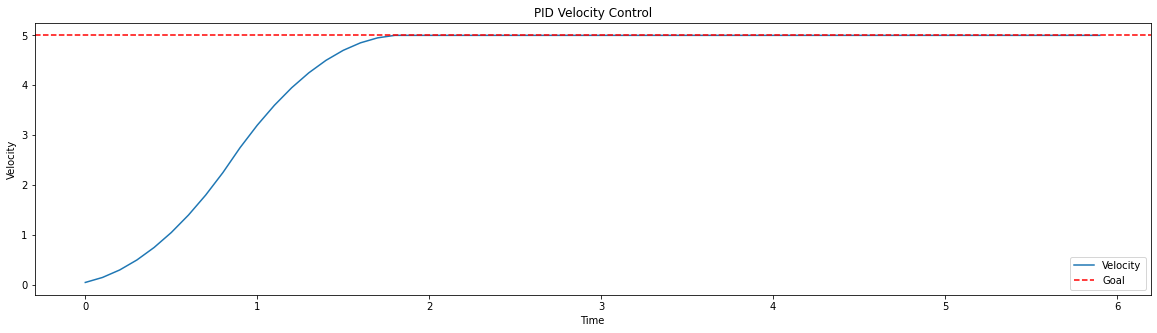

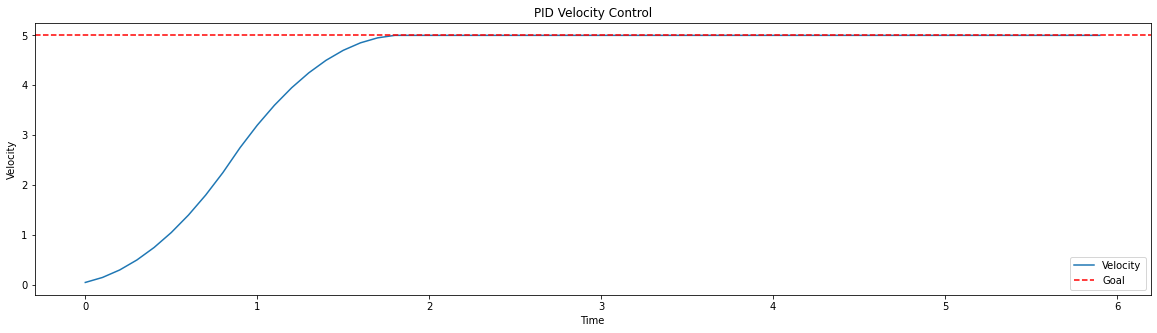

Convergence time: 2.00
Convergence time: 2.00


In [46]:
smaller_time_frame = 6

grad_pid = NewPID(intertia = moment_of_inertia, max_torque=max_torque, overshoot_threshold = 0.5, ideal_convergence_time = 1, logging = True, accel_damping=accel_damping)
grad_pid.reset()
gradient_params = grad_pid.auto_tune_gradient_descent(goal, max_iter=200, max_time = smaller_time_frame, learning_rate=200, auto_accept=True, tolerance = 0.001)
grad_pid.reset()
time = np.arange(0, smaller_time_frame, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = grad_pid.simulate_motion(goal)
    data.append(actual)


# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

# Run the simulation based on the pid values, and then plot the acceleration data
run_simulation(grad_pid, goal, smaller_time_frame, gradient_params, dt)

convergence_time = grad_pid.compute_convergence_time(goal, smaller_time_frame, gradient_params)
print(f"{Fore.GREEN}Convergence time: {convergence_time[0]:.2f}")


Stable oscillations detected: Kp=0.11, Tu=12.700000000000017, Aplitudes=[0.05275694194953484, 0.00926612011690775, 0.14949121758627903, 0.1015718318940575, 0.06449747419245977, 0.036118536092588194, 0.014682342019584738, 0.07640981543390435, 0.05347159331888118, 0.035619742759600115, 0.02185612268149839, 0.01136580669407472, 0.057507738551592524, 0.013334050618172277, 0.15289593841858018, 0.10448813866207551, 0.06699520072288845, 0.038257566033748525, 0.016514021325090056, 0.00033138550132338906, 0.054784443361294066, 0.03674422555088608, 0.02281917658982291, 0.012190530982733705]
Amplitude ratio: 5.693530979948128
Tuned PID values: Kp=0.03512758615073385, Ki=0.005531903330824221, Kd=0.14855807459006873


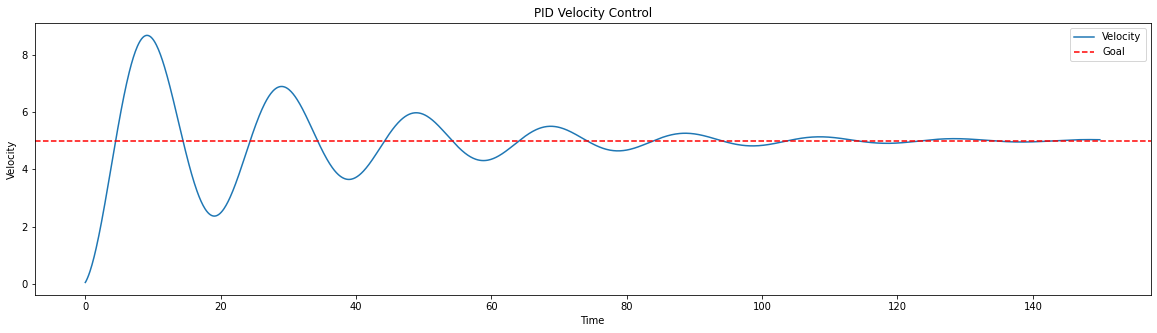

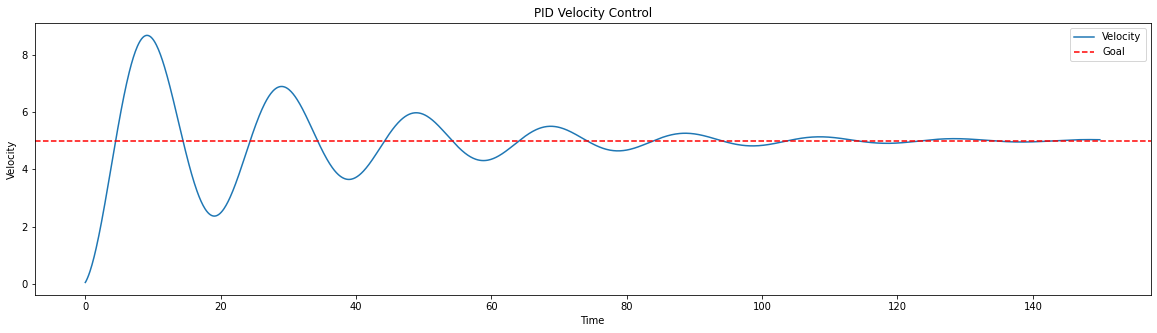

Convergence time: 24.50


(943.2794088015612, 24.500000000000078)

In [47]:
pid = NewPID(intertia=moment_of_inertia, max_torque=max_torque, logging=True, accel_damping=accel_damping)
pid.reset()
params = pid.auto_tune_zieger(goal, max_time = time_frame)
pid.reset()
time = np.arange(0, time_frame, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

# Run the simulation based on the pid values, and then plot the acceleration data
run_simulation(pid, goal, time_frame, params, dt)

In [48]:
# pid = NewPID(intertia=moment_of_inertia, max_torque=max_torque, logging=True, accel_damping=accel_damping)
# pid.reset()
# params = pid.auto_tune_range(goal, max_time=time_frame)
# pid.reset()
# time = np.arange(0, time_frame, dt)
# data = []

# # Print the convergence time 
# convergence_time = pid.compute_convergence_time(goal, time_frame)
# print(f"{Fore.GREEN}Convergence time: {convergence_time[0]:.2f}")

# # Try and run the simulation
# for _ in time:
#     actual = pid.simulate_motion(goal)
#     data.append(actual)

# # Run the simulation based on the pid values, and then plot the acceleration data
# run_simulation(pid, goal, time_frame, params, dt)

{'kp': 0.7682095084762424, 'ki': 0, 'kd': 0}


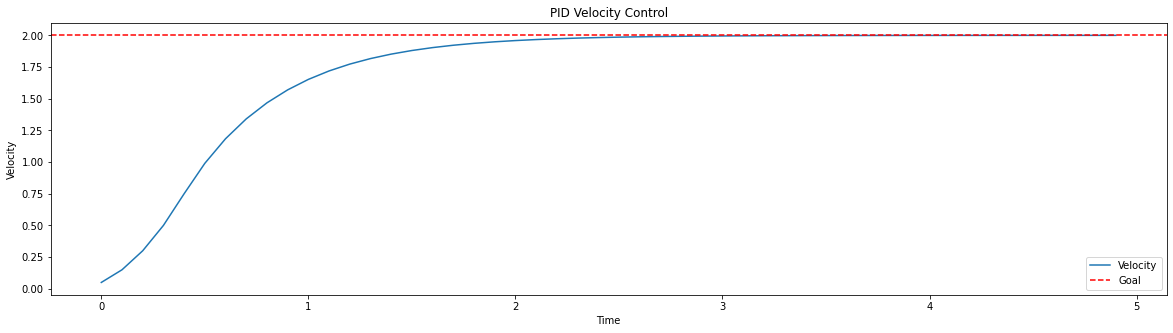

Convergence time: 1.90


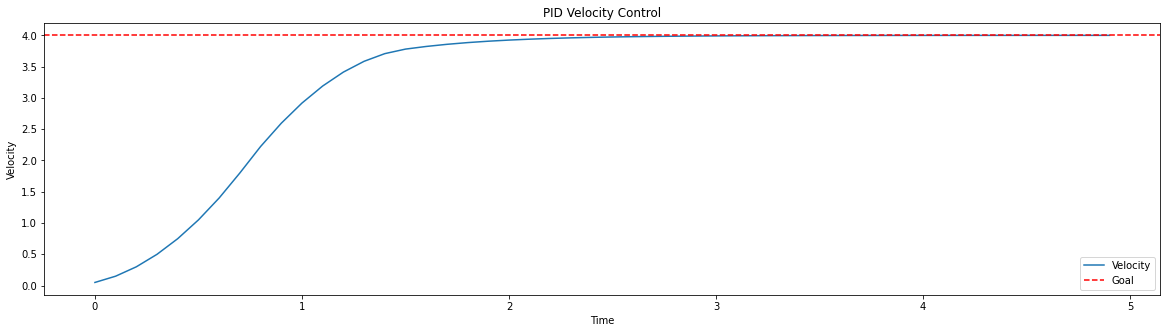

Convergence time: 2.10


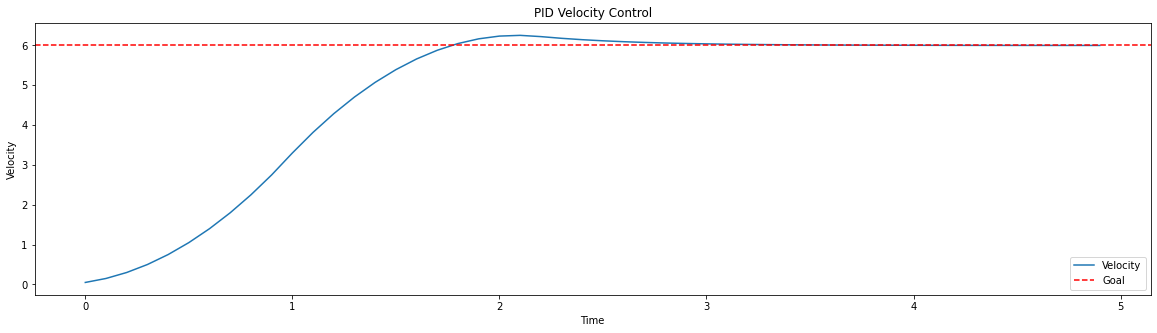

Convergence time: 2.80


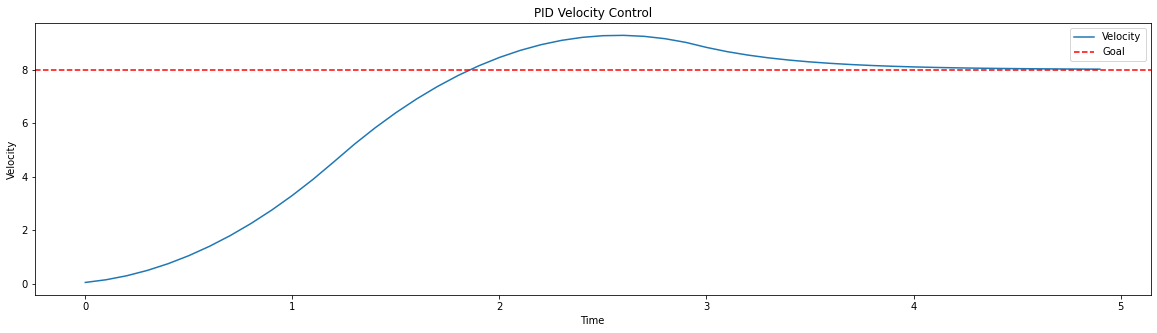

Convergence time: 4.30


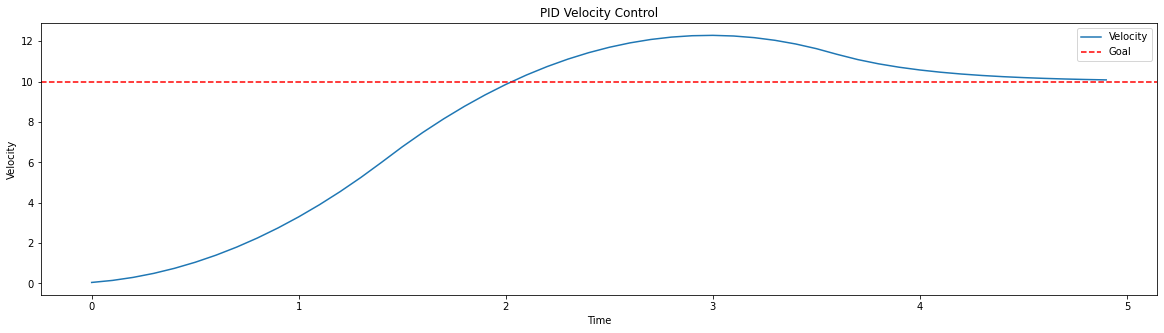

Convergence time: 5.10
-------------------------------
Total Error: 370.62
-------------------------------


,Single PID Error,Single PID Convergence
Goal: 2 m/s,13.508284,1.9
Goal: 4 m/s,33.513804,2.1
Goal: 6 m/s,60.740981,2.8
Goal: 8 m/s,104.489265,4.3
Goal: 10 m/s,158.368900,5.1


In [49]:
# Use the gradient_params
time_frame = 5
goals = [2, 4, 6, 8, 10]

# Print out the params being used
print(f"{gradient_params}")

# params = {'kp': 0.8180166666666647, 'ki': 0, 'kd': 0}
params = gradient_params

total_error = 0
data = {}

for goal in goals:
    error, convergence = run_simulation(grad_pid, goal, time_frame, params, dt)
    total_error += error
    data[f"Goal: {goal} m/s"] = {"Single PID Error": error, "Single PID Convergence": convergence}



print("-------------------------------")
print(f"Total Error: {total_error:.2f}")
print("-------------------------------")

df1 = pd.DataFrame(data).T  # Transpose to make the row names as the index
df1

# Discretized PID

In [50]:
class MultiPID:
    def __init__(self, difference, step = 1):
        self.difference = difference
        self.step = step
        self.tunings = {}

    def train(self):
        for i in range(1, self.difference, self.step):
            # Train a model based on the spec, using i as the goal
            print(f"Training for goal {i}")
            pid = NewPID(intertia=moment_of_inertia, max_torque=max_torque, logging=True, accel_damping=accel_damping, ideal_convergence_time = 1)
            pid.reset()
            params = pid.auto_tune_gradient_descent(i, max_iter=200, max_time = time_frame, learning_rate=200, auto_accept=True, tolerance = 0.001)
            self.tunings[i] = params

    def get(self, current, goal):
        # Get the PID values for the goal
        int_difference = int(abs(current - goal))
        tuning = self.tunings.get(int_difference, None)
        if tuning is None:
            # Find the closest tuning
            closest = min(self.tunings.keys(), key=lambda x:abs(x-int_difference))
            print(f"Using closest tuning for goal {goal}: {closest}")
            tuning = self.tunings.get(closest)
        return tuning

multi = MultiPID(15)
multi.train()

Training for goal 1
Progress: Iteration 199/200 Best Error: 0.26 Best PID: Kp=100.08261011162702, Ki=0, Kd=15.13372090944225                 Overshoot: 0.25  Oscillations: 0.00                 Randomized: 192                 Convergence : 1.4000000000000001                    

Final Tuned PID, Gradient Method: Kp=100.08261011162702, Ki=0, Kd=15.13372090944225, Error=0.25500000000000006, Overshoot=0.2500000000000002 Convergence Time=1.4000000000000001
Training for goal 2
Progress: Iteration 199/200 Best Error: 0.34 Best PID: Kp=1.254395889393383, Ki=0, Kd=0                 Overshoot: 0.09  Oscillations: 0.00                 Randomized: 193                 Convergence : 1.3                    00003                    9m

Final Tuned PID, Gradient Method: Kp=1.254395889393383, Ki=0, Kd=0, Error=0.34015722157517075, Overshoot=0.08751414238557098 Convergence Time=1.3
Training for goal 3
Progress: Iteration 199/200 Best Error: 0.61 Best PID: Kp=0.9298120737964823, Ki=0, Kd=0                

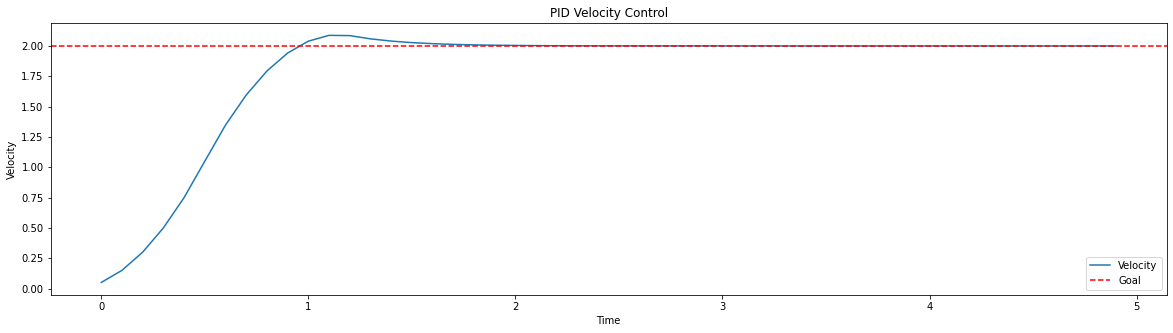

Convergence time: 1.30


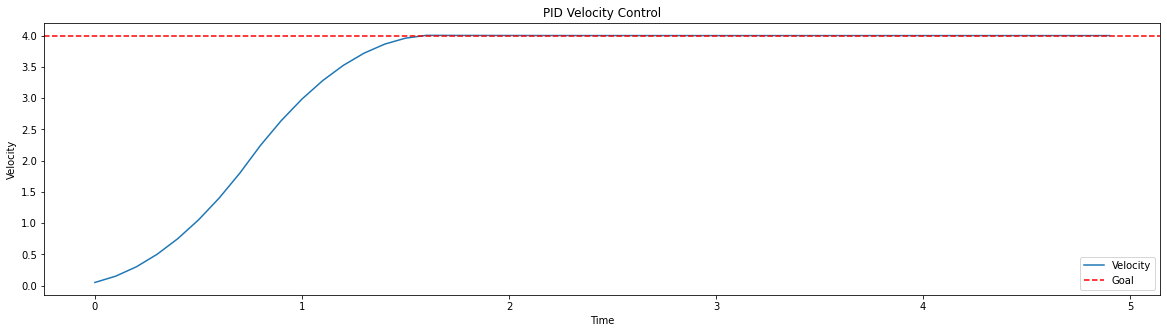

Convergence time: 1.80


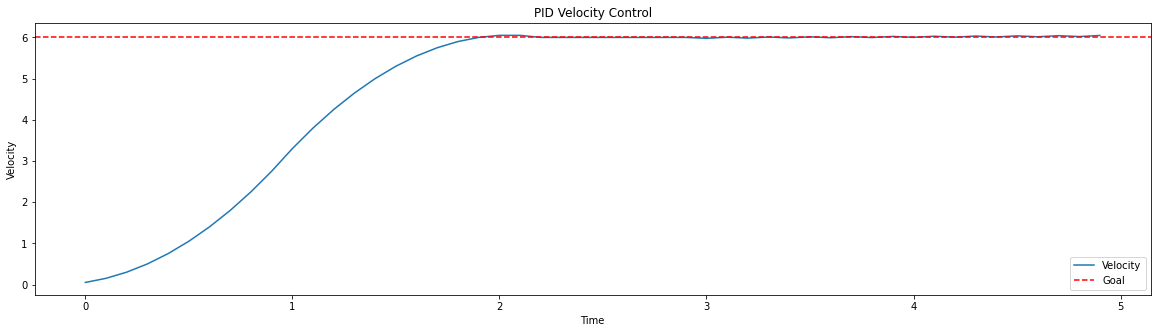

Convergence time: 2.20


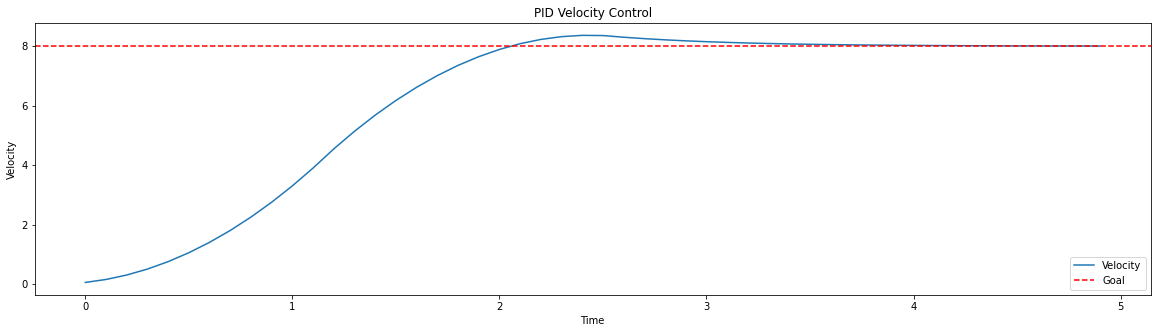

Convergence time: 3.50


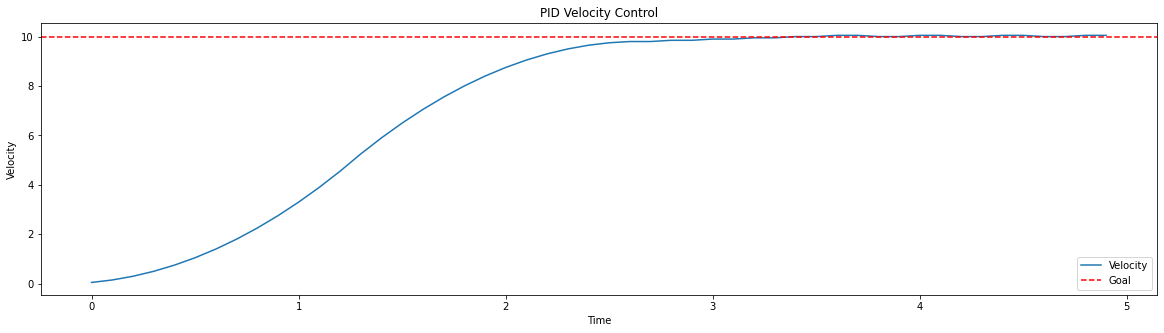

Convergence time: 3.30
-------------------------------
Total Error: 331.71
-------------------------------


,Multi PID Error,Multi PID Convergence
Goal: 2 m/s,10.920347,1.3
Goal: 4 m/s,31.803730,1.8
Goal: 6 m/s,59.980911,2.2
Goal: 8 m/s,95.004170,3.5
Goal: 10 m/s,134.000000,3.3


In [51]:
# Use the gradient_params
time_frame = 5
starting = 0
goals = [2, 4, 6, 8, 10]
total_error = 0

for goal in goals:
    params = multi.get(starting, goal)
    error, convergence = run_simulation(grad_pid, goal, time_frame, params, dt)
    total_error += error
    data[f"Goal: {goal} m/s"] = {"Multi PID Error": error, "Multi PID Convergence": convergence}

print("-------------------------------")
print(f"Total Error: {total_error:.2f}")
print("-------------------------------")

df2 = pd.DataFrame(data).T  # Transpose to make the row names as the index

df2

In [52]:
from IPython.display import display, HTML

# Combine DF 1 and DF 2 side by side
df_combined = pd.concat([df1, df2], axis=1, keys=['DF1', 'DF2'])
display(HTML(df_combined.to_html()))
